# 7.a. Implementing our first Shallow Neural Network in Numpy, with a Forward Propagation

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.1 (12/12/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Sklearn (tested on v0.0.post1)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Numpy
import numpy as np
# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
# Removing unecessary warnings (optional, just makes notebook outputs more readable)
import warnings
warnings.filterwarnings("ignore")

### Mock dataset generation

In this Notebook, we will go back to the appartments mock dataset from Notebooks 1-5. As before, we will try to come up with a model capable of predicting the price of an appartment based on some of its features. For that reason, the output, once again consists of the price of the appartment in millions of SGD.

The inputs, however, will this time consist of two parameter:
- the **surface** of the appartment, in sqm, just like before,
- and the **distance** between the appartment and the closest MRT station in meters.

We will generate a mock dataset by:
- randomly drawing **surfaces** between 40 sqm and 200sqm,
- randomly drawing **distances** between 50 and 1000m,
- generate prices by assuming that the average price is simply defined as

$$ avgprice = 100000 + 14373*surface + (1000 - distance)*1286 $$

- Finally, we will randomly apply a -/+ 10% variation on the average price to create some variance, and call that the output for a given sample.

Th mock dataset will then consist of $ N = 100 $ samples, sorted in the variable **n_points**.

To generate the said dataset, we have implement four helper functions below, following more or less the same logic as the functions in Notebooks 1-5.

In [2]:
# All helper functions
min_surf = 40
max_surf = 200
def surface(min_surf, max_surf):
    return round(np.random.uniform(min_surf, max_surf), 2)
min_dist = 50
max_dist = 1000
def distance(min_dist, max_dist):
    return round(np.random.uniform(min_dist, max_dist), 2)
def price(surface, distance):
    return round((100000 + 14373*surface + (1000 - distance)*1286)*(1 + np.random.uniform(-0.1, 0.1)))/1000000
n_points = 100
def create_dataset(n_points, min_surf, max_surf, min_dist, max_dist):
    surfaces_list = np.array([surface(min_surf, max_surf) for _ in range(n_points)])
    distances_list = np.array([distance(min_dist, max_dist) for _ in range(n_points)])
    inputs = np.array([[s, d] for s, d in zip(surfaces_list, distances_list)])
    outputs = np.array([price(s, d) for s, d in zip(surfaces_list, distances_list)]).reshape(n_points, 1)
    return surfaces_list, distances_list, inputs, outputs

Eventually, we will generate the dataset, with a given numpy seed for reproducibility.

In [3]:
# Generate dataset
np.random.seed(47)
surfaces_list, distances_list, inputs, outputs = create_dataset(n_points, min_surf, max_surf, min_dist, max_dist)
# Check a few entries of the dataset
print(surfaces_list.shape)
print(distances_list.shape)
print(inputs.shape)
print(outputs.shape)
print(inputs[0:10, :])
print(outputs[0:10])

(100,)
(100,)
(100, 2)
(100, 1)
[[ 58.16 572.97]
 [195.92 809.8 ]
 [156.6  349.04]
 [ 96.23  86.82]
 [153.22 817.92]
 [167.94 806.25]
 [143.29 315.92]
 [106.34 482.67]
 [152.96 427.77]
 [ 79.46 955.76]]
[[1.581913]
 [3.450274]
 [2.978769]
 [2.808258]
 [2.556398]
 [3.023983]
 [3.099523]
 [2.121069]
 [3.136544]
 [1.273443]]


### Visualising the dataset

Below we provide two plots to visualize the dataset and the possible relationship between our inputs and outputs.

The first plot, below, shows the relationship between prices (used as outputs) and each one of the inputs parameters seperately. Two linear relations seem to appear, namely:
- the prices seem to be linearly proportional to the surface,
- the prices seem to be linearly inversely proportional to the distance.

This was somewhat expected and modeled by our price function we defined earlier.

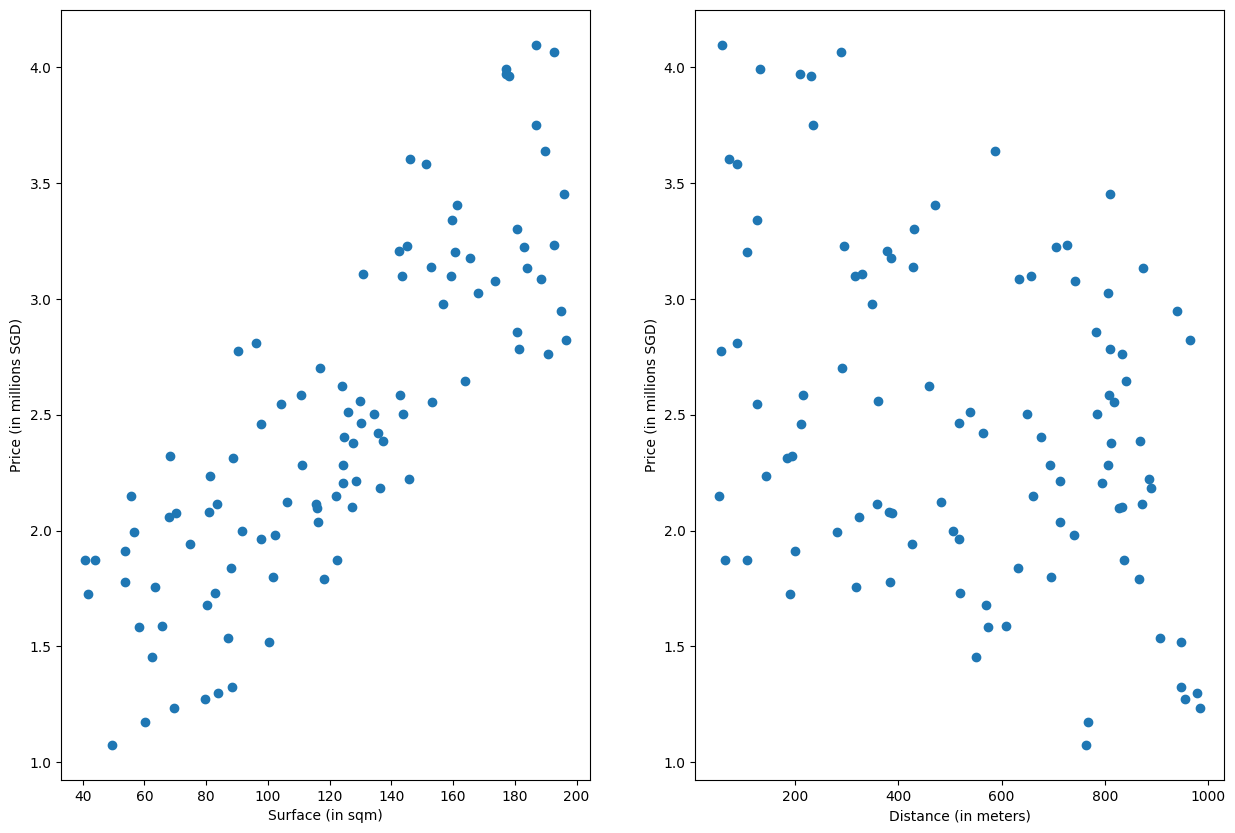

In [4]:
# Initialize matplotlib
fig, axs = plt.subplots(1, 2, figsize = (15, 10))
axs[0].scatter(surfaces_list, outputs)
axs[0].set_xlabel('Surface (in sqm)')
axs[0].set_ylabel('Price (in millions SGD)')
axs[1].scatter(distances_list, outputs)
axs[1].set_xlabel('Distance (in meters)')
axs[1].set_ylabel('Price (in millions SGD)')
# Display
plt.show()

Another possible plot to visualize the linearity consists of representing the average price of the appartments as a function of both the surfaces and the distances. The 3D plot below, again, confirms the linear relations between inputs and outputs.

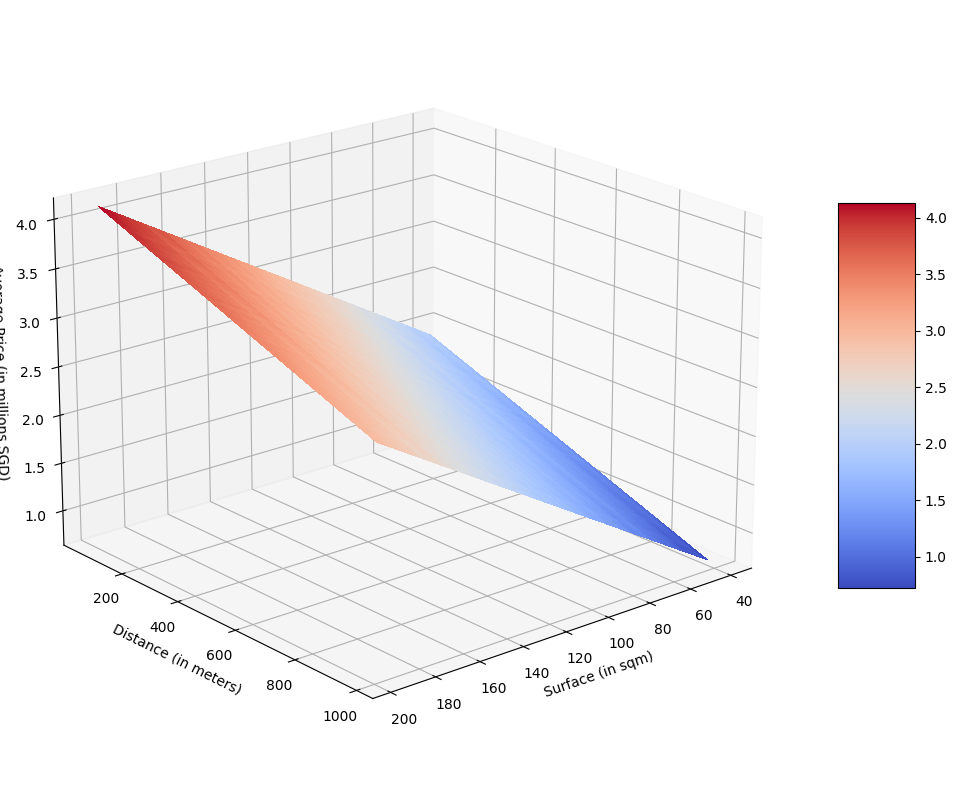

In [5]:
# Initialize plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (15, 10))
# Rework inputs and outputs as meshgrid
X, Y = np.meshgrid(sorted(surfaces_list), sorted(distances_list))
Z = np.round((100000 + 14373*X + (1000 - Y)*1286))/1000000
# Plot surface
surf = ax.plot_surface(X, Y, Z, cmap = cm.coolwarm,
                       linewidth = 0, antialiased = False)
# Axis labels
ax.set_xlabel('Surface (in sqm)')
ax.set_ylabel('Distance (in meters)')
ax.set_zlabel('Average Price (in millions SGD)')
# Rotate display around Z-axis
ax.view_init(20, 50)
# Display colorbar for Z values
fig.colorbar(surf, shrink = 0.5, aspect = 5)
# Show
plt.show()

### First model

In our first model, we can assume that the inputs are stored in a matrix $ X $, with size $ 100 \times 2 $ (100 samples and two inputs parameters, surface and distance). Each line then corresponds to a sample $ i \in \{1, 2, ..., 100\} $, and each column corresponds to either the surface $ s_i $ or the distance $ d_i $ for sample $ i $.

Let us now define a $ 2 \times 1 $ matrix $ W $ and a $ 1 \times 1 $ matrix $ b $ as follows:

$$ W = \left( \begin{array}{c} w_1 \\ w_2 \end{array} \right) $$

$$ b = \left( \begin{array}{c} b_1 \end{array} \right) $$

The operation $ Y = X \times W + b $ gives a $ 100 \times 1 $ matrix $ Y $ as a result, which happens to be the same matrix size as our outputs.

In a sense, this operation defines a linear model producing price predictions for our 100 samples in our dataset, based on the two given input parameters. More specifically, the prediction $ z_i $ for a sample $ i $ consists of

$$ z_i = w_1 d_i + w_2 s_i + b_1. $$

This can be tested below.

In [ ]:
# Let us define matrix W first, with two parameters w1 and w2.
# And the matrix b as well.
# Are these values randomly defined?
W = np.array([[14373/1000000], [-1286/1000000]]) # 14373/1000000 and -1286/1000000
b = np.ones(shape = (1, 1))*1.386 # 100000/1000000 + 1000*1286/1000000

In [21]:
# We can then implement the multiplication operation
# we defined above by using the matmul operation.
Z = np.matmul(inputs, W)
pred = Z + b
# We can then check the shape of the matrices we obtained
print(inputs.shape)
print(W.shape)
print(b.shape)
print(Z.shape)
print(pred.shape)
print(outputs.shape)

(100, 2)
(2, 1)
(1, 1)
(100, 1)
(100, 1)
(100, 1)


In [23]:
# If we compare the values in the outputs and the predictions,
# we realize that these are not too far apart.
print(pred[0:5, :])
print(outputs[0:5])

[[1.48509426]
 [3.16055536]
 [3.18794636]
 [2.65746327]
 [2.53638594]]
[[1.581913]
 [3.450274]
 [2.978769]
 [2.808258]
 [2.556398]]


### Defining a first Neural Network class, without any hidden layer and a forward propagation method

The model above, can technically be described as a minimal neural network, with two neurons only.

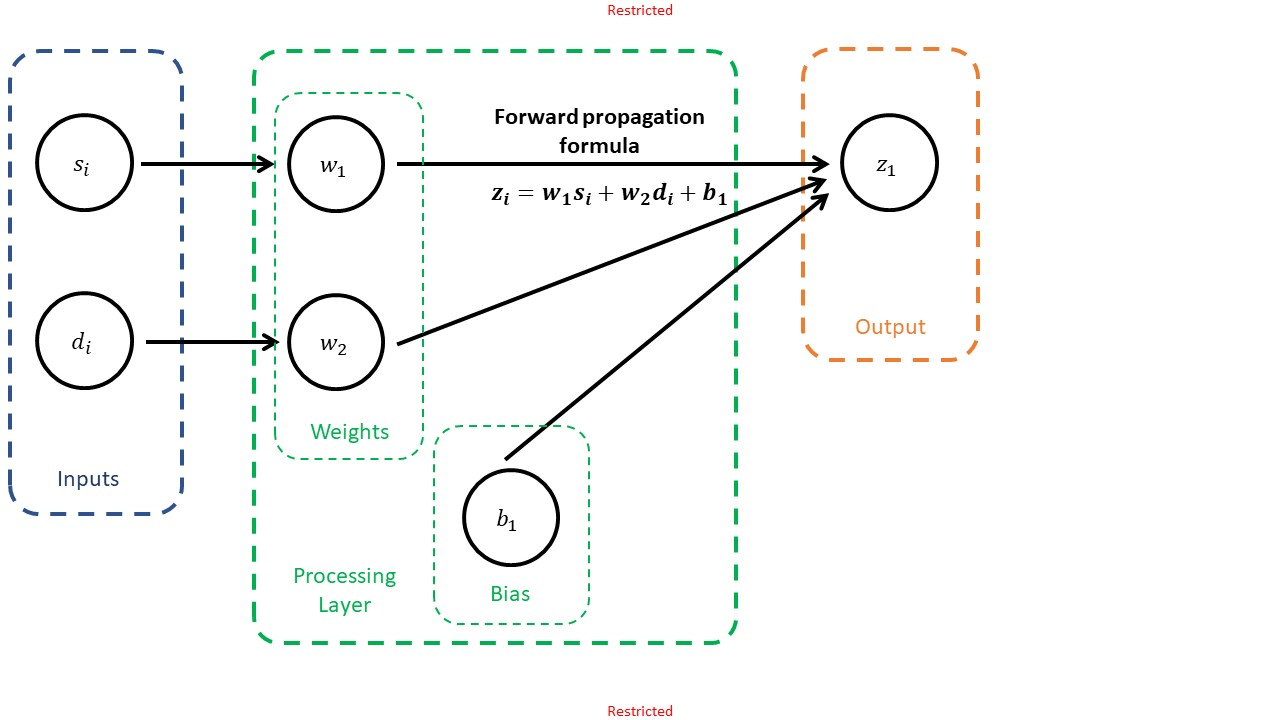

Something new that we should start doing is assembling these operations into a class, describing the neural network and its typical operations.

- We will start with an initialization method, whose purpose is only to assign the weights and bias matrices to their own attributes.
- We then define a **forward()** method, which performs the matrix multiplication responsible for the price prediction, that is $ Z = WX + b $.  $ X $ being a matrix of size $ N \times 2 $, with $ N $ the number of samples in our dataset and 2 corresponding to the number of inputs parameters (surface and distance).

In [8]:
class SimpleNeuralNet():
    
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
    def forward(self, x):
        Z = np.matmul(x, self.W)
        pred = Z + self.b
        return pred

Text

In [9]:
simple_neural_net = SimpleNeuralNet(W = np.array([[14373/1000000], [-1286/1000000]]), \
                                    b = np.ones(shape = (1, 1))*1.386)
print(simple_neural_net.__dict__)

{'W': array([[ 0.014373],
       [-0.001286]]), 'b': array([[1.386]])}


In [10]:
pred = simple_neural_net.forward(inputs)
print(pred)

[[1.48509426]
 [3.16055536]
 [3.18794636]
 [2.65746327]
 [2.53638594]
 [2.76296412]
 [3.03923405]
 [2.2937112 ]
 [3.03438186]
 [1.29897122]
 [2.05812888]
 [1.87920476]
 [2.11962392]
 [1.84029981]
 [2.94847796]
 [2.05259819]
 [1.12239528]
 [3.76762625]
 [2.12353725]
 [1.33242109]
 [3.22227485]
 [1.26696912]
 [3.5176671 ]
 [1.88986628]
 [3.66119027]
 [3.44993451]
 [2.31527494]
 [3.35735384]
 [2.29021042]
 [2.12021244]
 [2.50222666]
 [1.46965185]
 [1.74028108]
 [2.95190025]
 [3.09159629]
 [3.05628542]
 [2.83033185]
 [1.90851045]
 [2.1279975 ]
 [2.13444796]
 [2.17447982]
 [2.37228055]
 [1.94513032]
 [2.51843541]
 [1.57455321]
 [1.90410213]
 [1.92549968]
 [2.98118327]
 [1.88687349]
 [2.06641542]
 [2.15285744]
 [2.4252188 ]
 [1.54462893]
 [2.60787969]
 [1.83863448]
 [2.84418343]
 [1.95501787]
 [1.66164666]
 [2.7908174 ]
 [2.61545925]
 [3.39201275]
 [1.89774514]
 [3.78483706]
 [1.1145215 ]
 [3.43250111]
 [3.26705252]
 [1.80865922]
 [3.27735019]
 [2.09200314]
 [1.6093546 ]
 [3.10883395]
 [3.55

### On the impact of parameters W and b

We can also amend the Neural Network class to add a **MSE_loss()**, which will first perform predictions with all the input samples and will then compare them to the expected outputs, computing the mean square error value in the process. We can then use this method to check the performance of the parameters $ W $ and $ b $ that we have chosen.

In [ ]:
class SimpleNeuralNet():
    
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
    def forward(self, x):
        Z = np.matmul(x, self.W)
        pred = Z + self.b
        return pred
    
    def MSE_loss(self, inputs, outputs):
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        losses = (pred - outputs_re)**2
        loss = np.sum(losses)/outputs.shape[0]
        return loss

We can then use this **MSE_loss()** method to evaluate how different networks, with different sets of parameters $ W $ and $ b $ might perform at predictions. Running the cells below shows how the loss function increases the further away the parameters $ W $ and $ b $ move from the values used in the **price()** functions used in the mock dataset generation.

In [12]:
W_model1 = np.array([[14373/1000000], [-1286/1000000]]) # 14373/1000000 and -1286/1000000
b_model1 = np.ones(shape = (1, 1))*1.386 # 100000/1000000 + 1000*1286/1000000
simple_neural_net1 = SimpleNeuralNet(W = W_model1, b = b_model1)
loss1 = simple_neural_net1.MSE_loss(inputs, outputs)
print(loss1)

0.024469052004118513


In [13]:
W_model2 = np.array([[20000/1000000], [-800/1000000]])
b_model2 = np.ones(shape = (1, 1))*1.1
simple_neural_net2 = SimpleNeuralNet(W = W_model2, b = b_model2)
loss2 = simple_neural_net2.MSE_loss(inputs, outputs)
print(loss2)

0.5263021482437401


In [14]:
W_model3 = np.array([[30000/1000000], [-400/1000000]])
b_model3 = np.ones(shape = (1, 1))*0.7
simple_neural_net3 = SimpleNeuralNet(W = W_model3, b = b_model3)
loss3 = simple_neural_net3.MSE_loss(inputs, outputs)
print(loss3)

3.4384272065304593


### Defining a Neural Network class, with a single hidden layer

Text

In [15]:
class ShallowNeuralNet():
    
    def __init__(self, n_x, n_h, n_y):
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        self.W1 = np.random.randn(n_x, n_h)*0.1
        self.b1 = np.random.randn(1, n_h)*0.1
        self.W2 = np.random.randn(n_h, n_y)*0.1
        self.b2 = np.random.randn(1, n_y)*0.1
        
    def forward(self, x):
        Z1 = np.matmul(x, self.W1)
        Z1_b = Z1 + self.b1
        Z2 = np.matmul(Z1_b, self.W2)
        Z2_b = Z2 + self.b2
        return Z2_b
    
    def MSE_loss(self, inputs, outputs):
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        losses = (pred - outputs_re)**2
        loss = np.sum(losses)/outputs.shape[0]
        return loss

In [16]:
# Define neural network structure
n_x = 2
n_h = 4
n_y = 1
shallow_neural_net = ShallowNeuralNet(n_x, n_h, n_y)
print(shallow_neural_net.__dict__)

{'n_x': 2, 'n_h': 4, 'n_y': 1, 'W1': array([[-0.10476816,  0.18570216,  0.03204007, -0.10951262],
       [-0.13867874, -0.03539496, -0.02856421,  0.20592501]]), 'b1': array([[ 0.0232776 , -0.16122469,  0.00718537,  0.06663351]]), 'W2': array([[ 0.03321156],
       [-0.0336505 ],
       [ 0.04977554],
       [-0.1794089 ]]), 'b2': array([[0.03460341]])}


In [17]:
pred = shallow_neural_net.forward(inputs)
print(pred.shape)
print(outputs.shape)
print(pred[0:5])
print(outputs[0:5])

(100, 1)
(100, 1)
[[-23.24055489]
 [-31.54945952]
 [-12.75105332]
 [ -2.49026451]
 [-32.3803654 ]]
[[1.581913]
 [3.450274]
 [2.978769]
 [2.808258]
 [2.556398]]


### What's next?

Text

In [18]:
loss = shallow_neural_net.MSE_loss(inputs, outputs)
print(loss)

677.625448852107


In [19]:
np.random.seed(963) 
shallow_neural_net1 = ShallowNeuralNet(n_x, n_h, n_y)
loss1 = shallow_neural_net1.MSE_loss(inputs, outputs)
shallow_neural_net2 = ShallowNeuralNet(n_x, n_h, n_y)
loss2 = shallow_neural_net2.MSE_loss(inputs, outputs)
shallow_neural_net3 = ShallowNeuralNet(n_x, n_h, n_y)
loss3 = shallow_neural_net3.MSE_loss(inputs, outputs)
shallow_neural_net4 = ShallowNeuralNet(n_x, n_h, n_y)
loss4 = shallow_neural_net4.MSE_loss(inputs, outputs)
print(loss1, loss2, loss3, loss4)

21.318364917457647 58.190236579106184 4.770288142049728 0.2093294704434788
